### 0. Imports

In [30]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# append parent folder to path
import sys 
sys.path.append("..")

# import database connection support functions
from src.support.data_load_support import connect_to_database, connect_and_query, alter_update_query
from src.support.data_visualization_support import plot_bar_labels

# import env variables
import os
from dotenv import load_dotenv
load_dotenv()
database_credentials = {
    "username": os.getenv("DB_USERNAME"),
    "password": os.getenv("DB_PASSWORD")
}

# linear regression fit 
from scipy.stats import linregress


# 1. Introduction to this notebook

# 2. Analysis

- Análisis de Datos: Debes realizar los siguientes análisis utilizando Python y Pandas:

    - Comparación de Precios entre Supermercados: Determinar qué supermercados ofrecen los precios más bajos y cuáles son más caros para cada producto.

In [ ]:



    - Comparación de Precios Promedio: Calcular y comparar los precios promedio de cada producto en diferentes supermercados.

Add latest price column to supermarkets_products table

In [31]:
# create new column latest price in supermarkets_products
alter_query = """
ALTER TABLE supermarkets_products 
ADD COLUMN latest_price NUMERIC;
"""

alter_update_query("comparativa_supermercados",database_credentials,alter_query)

# fill in new column with latest price values
update_query = """
WITH most_recent_date AS (
			SELECT supermarket_product_id , price_amount,date, MAX(date) OVER(PARTITION BY supermarket_product_id) AS most_recent
			FROM prices p),

latest_price AS (SELECT supermarket_product_id, price_amount, date
FROM most_recent_date
WHERE date = most_recent)

UPDATE supermarkets_products s
SET latest_price = l.price_amount
FROM latest_price l
WHERE l.supermarket_product_id = s.supermarket_product_id;
"""

alter_update_query("comparativa_supermercados",database_credentials, update_query)

What are the main category price comparison between products?

In [35]:
query = """
SELECT s2.supermarket_name, p.units, ROUND(AVG(sp.latest_price /(p.quantity * p.volume_weight)),2) AS euro_per_liter, COUNT(*) n_products
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
GROUP BY s2.supermarket_name,  p.units
ORDER BY euro_per_liter;
"""

supermarket_average = connect_and_query("comparativa_supermercados",database_credentials, query, columns="query")
supermarket_average

,supermarket_name,units,euro_per_liter,n_products
0,mercadona,l,3.21,40
1,dia,l,4.23,124
2,eroski,l,5.16,211
3,alcampo,l,5.55,350
4,hipercor,l,11.75,469
5,carrefour,l,13.76,226


Here we can see that, in general, mercadona has a less expensive price per liter. That can be greatly influenced by the fact that it is the only supermarket that sells allmost exclusively its one white label brand.

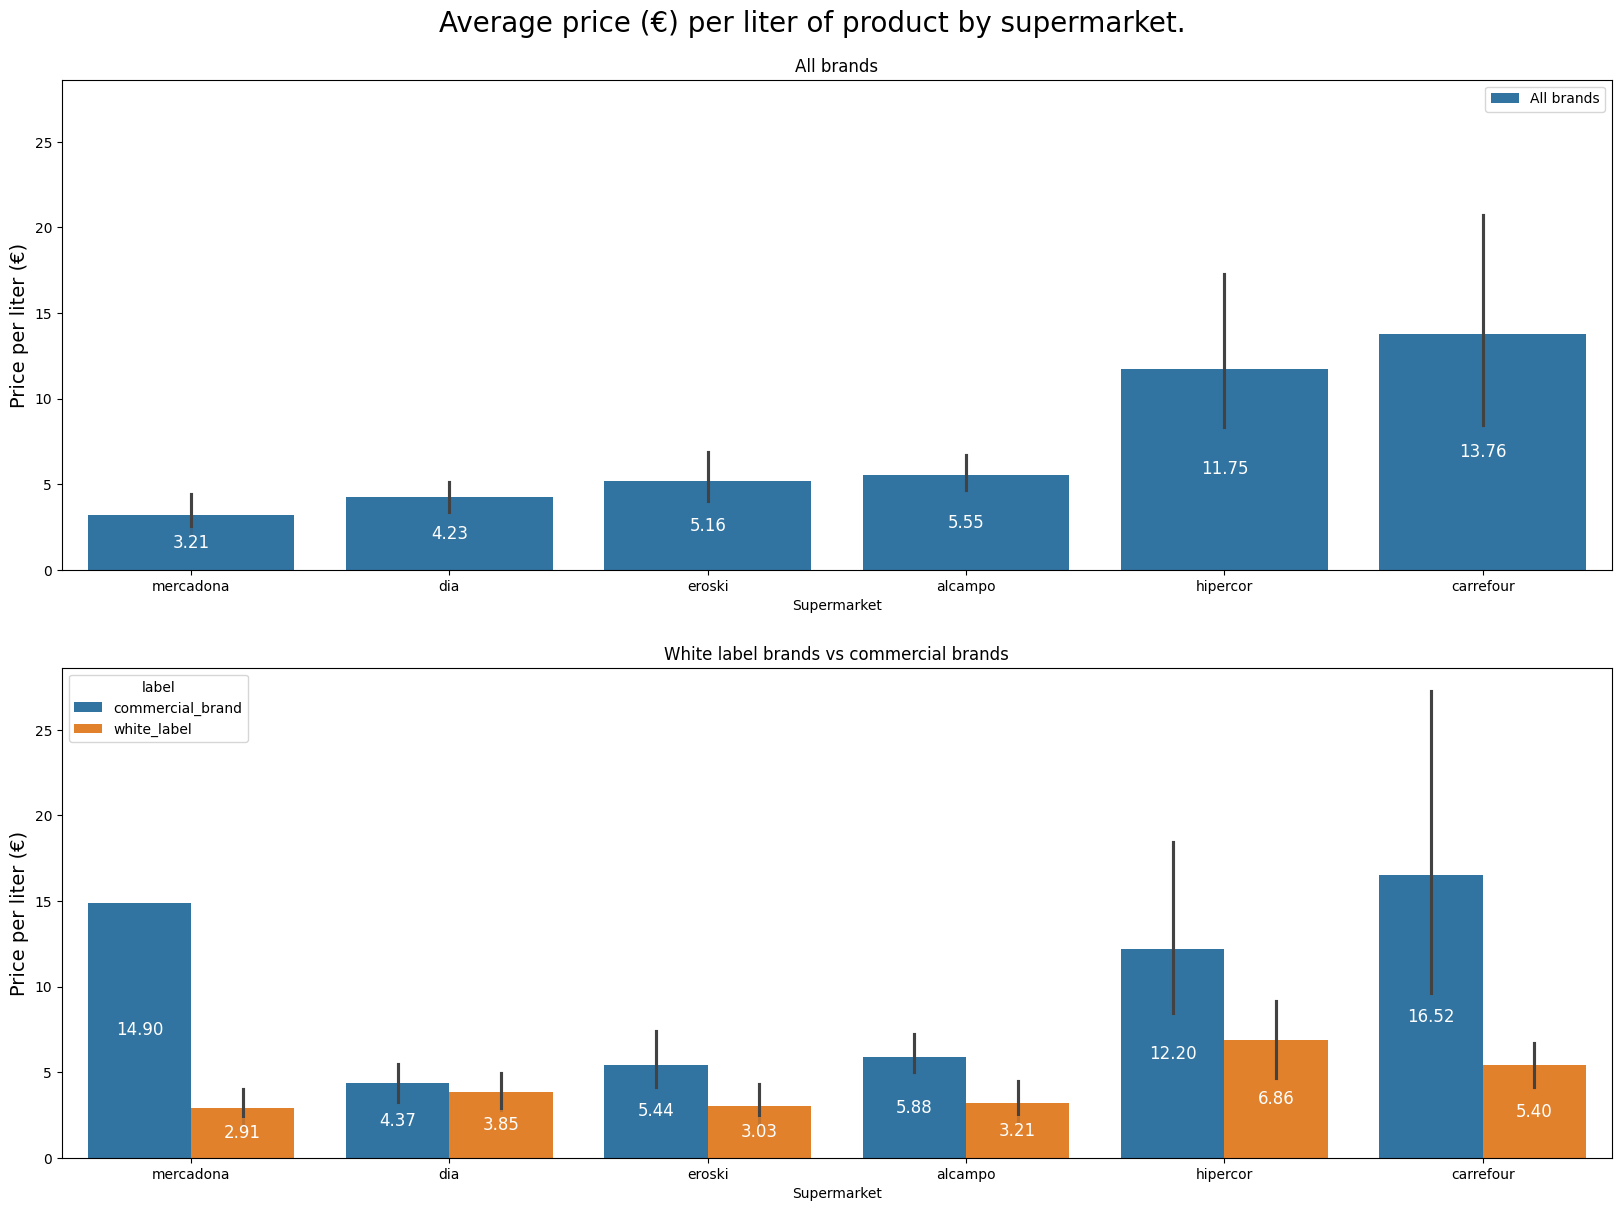

In [37]:
query1 = """
SELECT s2.supermarket_name, sp.latest_price / (p.quantity * p.volume_weight) AS euro_per_liter
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
ORDER BY euro_per_liter;
"""


price_per_category_plot_data = connect_and_query("comparativa_supermercados",database_credentials, query1, columns="query")

query2 = """
SELECT s2.supermarket_name, sp.latest_price / (p.quantity * p.volume_weight) AS euro_per_liter, 
        CASE WHEN b.brand_name IN ('alcampo','eroski','hacendado','carrefour','dia','hipercor','el corte ingles') THEN 'white_label'
        ELSE 'commercial_brand' END as label
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
INNER JOIN brands b
	ON b.brand_id = p.brand_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
-- AND b.brand_name IN ('alcampo','eroski','hacendado','carrefour','dia','hipercor','el corte ingles')
ORDER BY euro_per_liter;
"""

price_per_category_white_label_plot_data = connect_and_query("comparativa_supermercados",database_credentials, query2, columns="query")

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20, 14), sharey=True) 

plt.suptitle("Average price (€) per liter of product by supermarket.", fontsize=20, y=0.93)

##First plot
sns.barplot(data=price_per_category_plot_data,
             x="supermarket_name",
             y="euro_per_liter",
             ax=ax1,
             order=supermarket_average["supermarket_name"],
             estimator="mean",
             label="All brands")

# ax title
ax1.set_title("All brands")

# adding data labels
plot_bar_labels(ax1)


ax1.set_ylabel("Price per liter (€)", fontsize=14)
ax1.set_xlabel("Supermarket")


## second plot
sns.barplot(data=price_per_category_white_label_plot_data,
             x="supermarket_name",
             y="euro_per_liter",
             hue= "label",
             ax=ax2,
             order=supermarket_average["supermarket_name"],
             estimator="mean")

# ax title
ax2.set_title("White label brands vs commercial brands")

# adding data labels
plot_bar_labels(ax2)


ax2.set_ylabel("Price per liter (€)", fontsize=14)
ax2.set_xlabel("Supermarket")


plt.show()

Here we can see that all supermarket chains see their average price per liter of product reduced when focusing on their on white label brand. The most expensive chains see their prices reduced the most, although their prices stay more expensive. That indicates that they focus on high-end products, which aligns with hipercor and carrefour.

There is one very high bar on Mercadona. If looking closely, one can see that it has no errorbar, meaning that it's just one occurrence and it is probably some brand or miscalculated quantity.

In [4]:
query = """
SELECT c.category_name, p.units, ROUND(AVG(sp.latest_price /(p.quantity * p.volume_weight)),2) AS euro_per_liter, s2.supermarket_name,  COUNT(*) n_products
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
GROUP BY s2.supermarket_name, c.category_name, p.units
ORDER BY c.category_name, euro_per_liter;
"""

supermarket_average_category = connect_and_query("comparativa_supermercados",database_credentials, query, columns="query")
supermarket_average_category

,category_name,units,euro_per_liter,supermarket_name,n_products
0,aceite_de_girasol,l,1.43,mercadona,2
1,aceite_de_girasol,l,2.02,eroski,12
2,aceite_de_girasol,l,2.37,hipercor,11
3,aceite_de_girasol,l,2.81,alcampo,17
4,aceite_de_girasol,l,3.21,dia,7
5,aceite_de_girasol,l,52.88,carrefour,15
6,aceite_de_oliva,l,8.99,mercadona,11
7,aceite_de_oliva,l,10.77,dia,37
8,aceite_de_oliva,l,12.16,alcampo,133
9,aceite_de_oliva,l,12.41,eroski,72


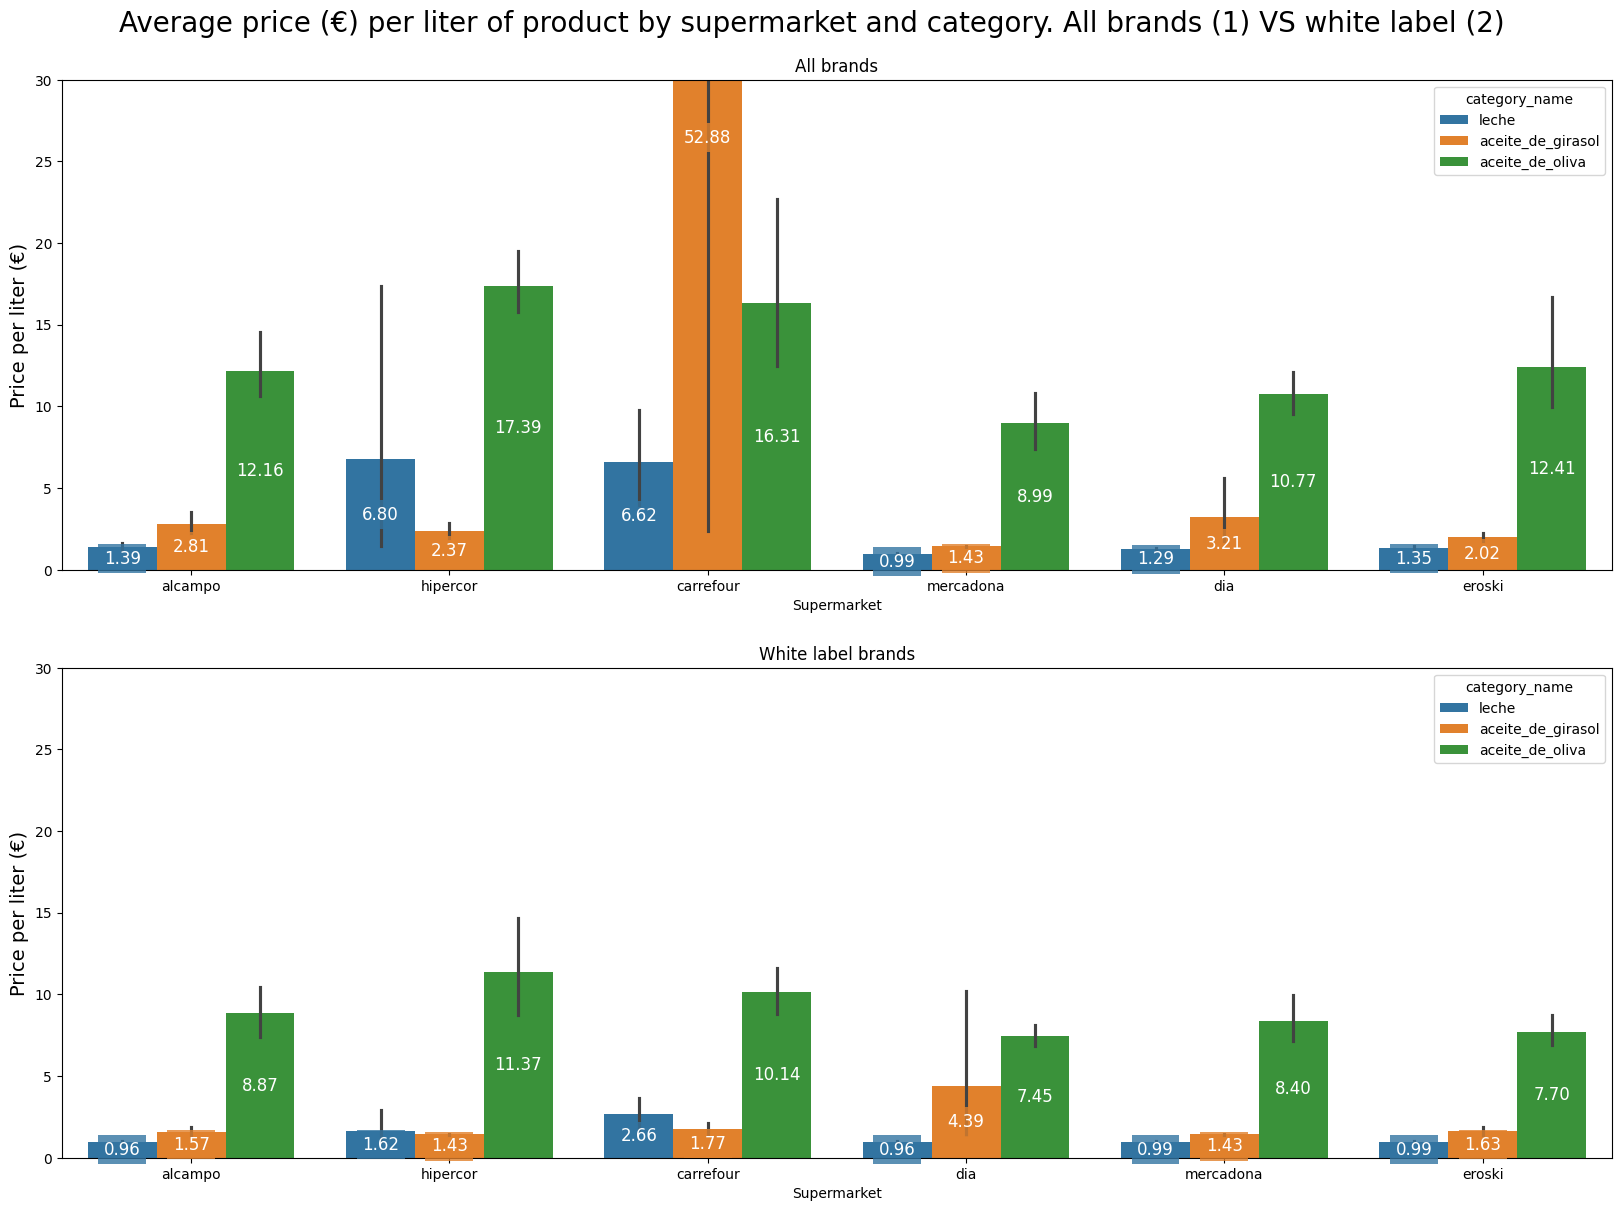

In [39]:
query1 = """
SELECT s2.supermarket_name, category_name, sp.latest_price / (p.quantity * p.volume_weight) AS euro_per_liter
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
ORDER BY euro_per_liter;
"""


price_per_category_plot_data = connect_and_query("comparativa_supermercados",database_credentials, query1, columns="query")

query2 = """
SELECT s2.supermarket_name, category_name, sp.latest_price / (p.quantity * p.volume_weight) AS euro_per_liter
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
INNER JOIN brands b
	ON b.brand_id = p.brand_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
AND b.brand_name IN ('alcampo','eroski','hacendado','carrefour','dia','hipercor','el corte ingles')
ORDER BY euro_per_liter;
"""

price_per_category_white_label_plot_data = connect_and_query("comparativa_supermercados",database_credentials, query2, columns="query")

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20, 14), sharey=True) 

plt.suptitle("Average price (€) per liter of product by supermarket and category. All brands (1) VS white label (2)", fontsize=20, y=0.93)

##First plot
sns.barplot(data=price_per_category_plot_data,
             x="supermarket_name",
             y="euro_per_liter",
             hue="category_name",
             ax=ax1,
            #  order=supermarket_average["supermarket_name"],
             estimator="mean")

# ax title
ax1.set_title("All brands")

# adding data labels
plot_bar_labels(ax1)

ax1.set_ylim(0,30)
ax1.set_ylabel("Price per liter (€)", fontsize=14)
ax1.set_xlabel("Supermarket")


## second plot
sns.barplot(data=price_per_category_white_label_plot_data,
             x="supermarket_name",
             y="euro_per_liter",
             hue="category_name",
             ax=ax2,
            #  order=supermarket_average["supermarket_name"],
             estimator="mean")

# ax title
ax2.set_title("White label brands")

# adding data labels
plot_bar_labels(ax2)


ax2.set_ylabel("Price per liter (€)", fontsize=14)
ax2.set_xlabel("Supermarket")


plt.show()

### Análisis de la Dispersión de Precios: Evaluar la variabilidad de los precios de un mismo producto en diferentes supermercados.

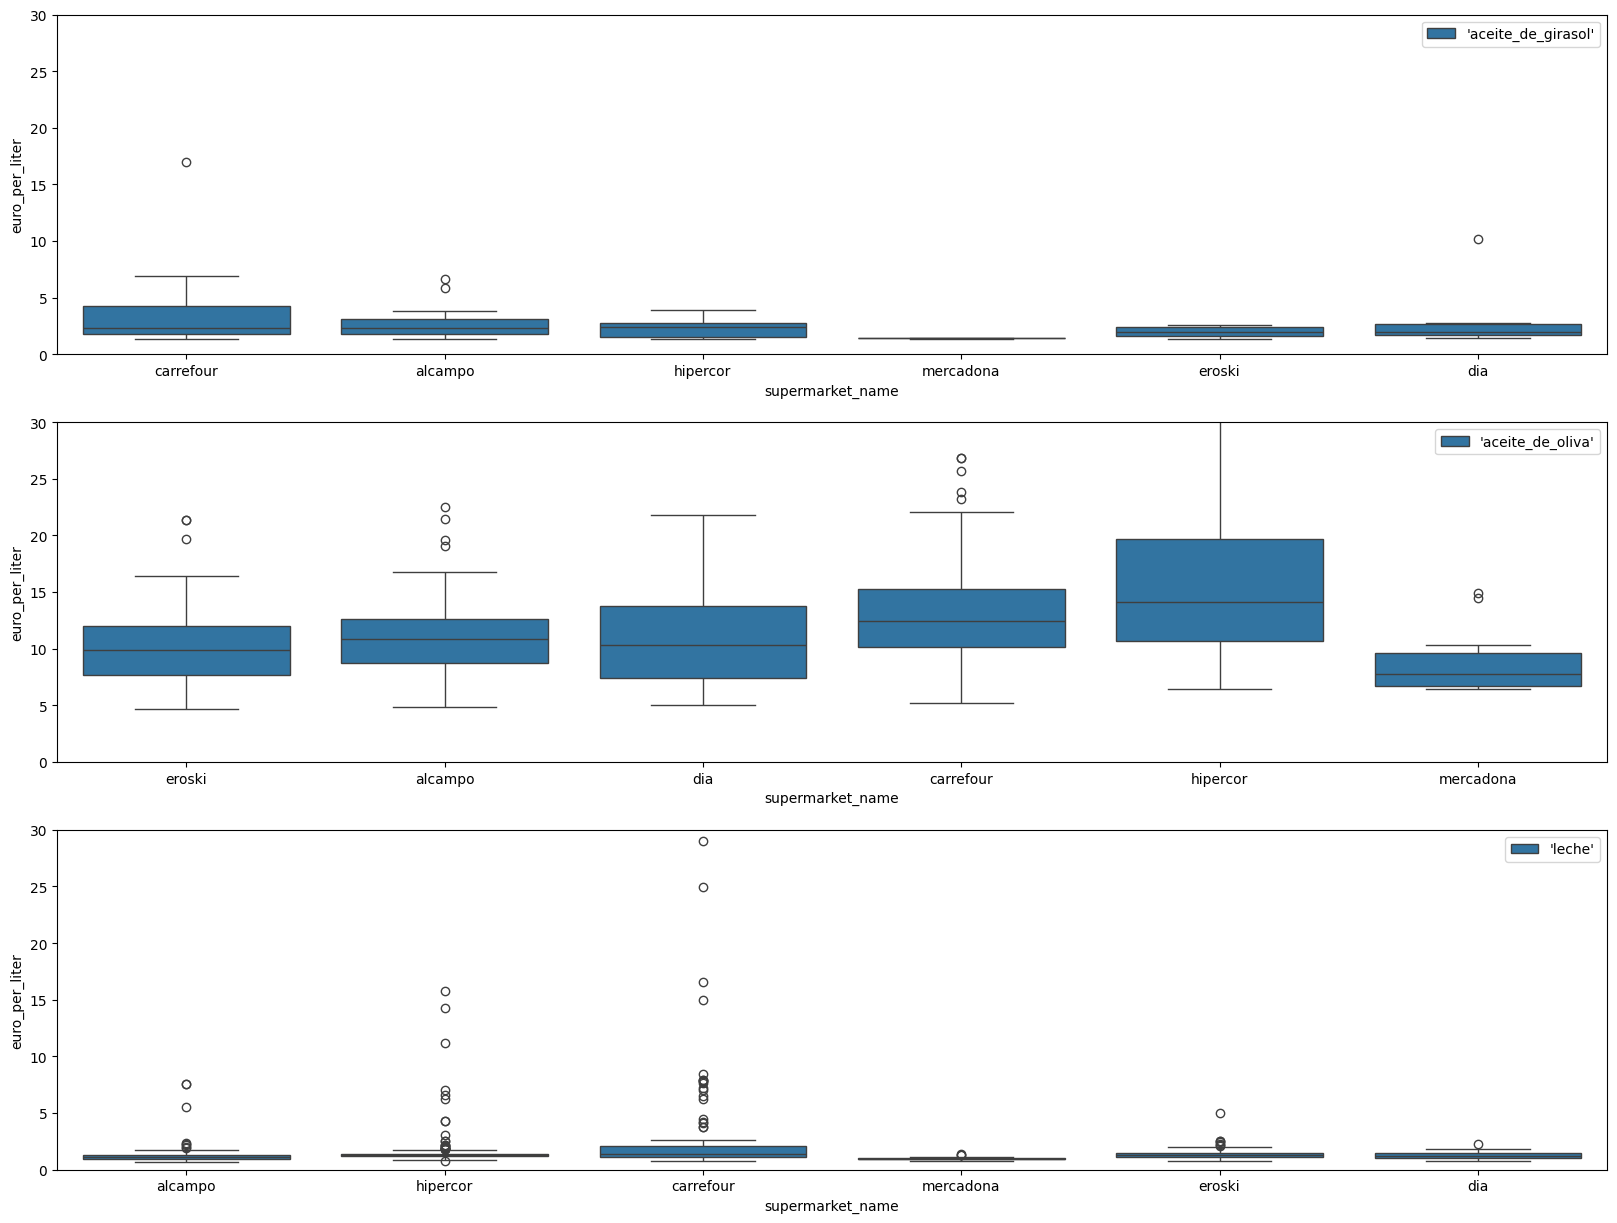

In [117]:
fig, axes = plt.subplots(3,1,figsize=(20,15))

axes_flat = axes.flat

for ax, category in zip(axes_flat, ["'aceite_de_girasol'","'aceite_de_oliva'","'leche'"]):

	query = f"""
	SELECT s2.supermarket_name, category_name, subcategory_name, CONCAT(category_name, ' ', subcategory_name) AS subcategory_full, sp.latest_price / (p.quantity * p.volume_weight) AS euro_per_liter
	FROM products p 
	INNER JOIN subcategories s 
		ON p.subcategory_id =s.subcategory_id 
	INNER JOIN categories c 
		ON s.category_id = c.category_id 
	INNER JOIN supermarkets_products sp 
		ON p.product_id = sp.product_id
	INNER JOIN supermarkets s2
		ON sp.supermarket_id = s2.supermarket_id 
	INNER JOIN brands b
		ON b.brand_id = p.brand_id 
	WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
	AND units IS NOT NULL 
	AND units != 'g'
	AND s.subcategory_name NOT LIKE '%otras%'
	AND subcategory_name != 'cabra'
	AND category_name = {category}
	ORDER BY euro_per_liter;
	"""

	spread_analysis = connect_and_query("comparativa_supermercados", database_credentials, query)

	sns.boxplot(
		data=spread_analysis,
		x="supermarket_name",
		y="euro_per_liter",
		label=category,
		ax=ax
	)
	ax.set_ylim(0,30)


plt.show()



In [104]:
query = """
SELECT supermarket_name, category_name, ROUND(AVG(sp.latest_price / (p.quantity * p.volume_weight)),2) AS avg,
    ROUND(MIN(sp.latest_price / (p.quantity * p.volume_weight)),2) AS min,
    PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY sp.latest_price / (p.quantity * p.volume_weight)) AS percentile_25,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY sp.latest_price / (p.quantity * p.volume_weight)) AS median,
    PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY sp.latest_price / (p.quantity * p.volume_weight)) AS percentile_75,
    ROUND(MAX(sp.latest_price / (p.quantity * p.volume_weight)),2) AS max
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
INNER JOIN brands b
	ON b.brand_id = p.brand_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
AND subcategory_name != 'cabra'
GROUP BY supermarket_name,category_name
ORDER BY supermarket_name,category_name;
"""
spread_analysis = connect_and_query("comparativa_supermercados", database_credentials, query)
spread_analysis

,supermarket_name,category_name,avg,min,percentile_25,median,percentile_75,max
0,alcampo,aceite_de_girasol,2.81,1.38,1.820000,2.340000,3.100000,6.67
1,alcampo,aceite_de_oliva,12.16,4.85,8.730000,10.878000,12.620000,166.00
2,alcampo,leche,1.25,0.68,0.950000,1.106667,1.320000,7.59
3,carrefour,aceite_de_girasol,52.88,1.35,1.830000,2.350000,4.298333,740.80
4,carrefour,aceite_de_oliva,16.31,5.19,10.150000,12.490000,15.295000,291.00
5,carrefour,leche,6.68,0.77,1.140000,1.360000,2.045000,82.25
6,dia,aceite_de_girasol,3.21,1.43,1.704000,1.996000,2.700000,10.20
7,dia,aceite_de_oliva,10.77,4.99,7.370000,10.333333,13.800000,21.85
8,dia,leche,1.28,0.79,1.059091,1.210000,1.460000,2.25
9,eroski,aceite_de_girasol,2.02,1.38,1.630000,1.940000,2.426000,2.59


### Cheapest and most expensive

In [40]:
query = """WITH mean_price_per_unit AS (
SELECT s2.supermarket_name, c.category_name, p.units, ROUND(AVG(sp.latest_price /(p.quantity * p.volume_weight)),2) AS euro_per_liter, 
		COUNT(*) n_products, ROW_NUMBER() OVER(PARTITION BY category_name ORDER BY SUM(sp.latest_price) / SUM(p.quantity * p.volume_weight) ASC)
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
INNER JOIN brands b
	ON b.brand_id = p.brand_id
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
AND b.brand_name IN ('alcampo','eroski','hacendado','carrefour','dia','hipercor','el corte ingles')
AND sp.latest_price /(p.quantity * p.volume_weight) < 50
GROUP BY s2.supermarket_name, c.category_name,  p.units
ORDER BY category_name, euro_per_liter)

SELECT supermarket_name, category_name, euro_per_liter
FROM mean_price_per_unit
WHERE ROW_NUMBER = 1;"""

supermarket_cheapest_category = connect_and_query("comparativa_supermercados",database_credentials, query, columns="query")
supermarket_cheapest_category

,supermarket_name,category_name,euro_per_liter
0,mercadona,aceite_de_girasol,1.43
1,eroski,aceite_de_oliva,7.70
2,dia,leche,0.96


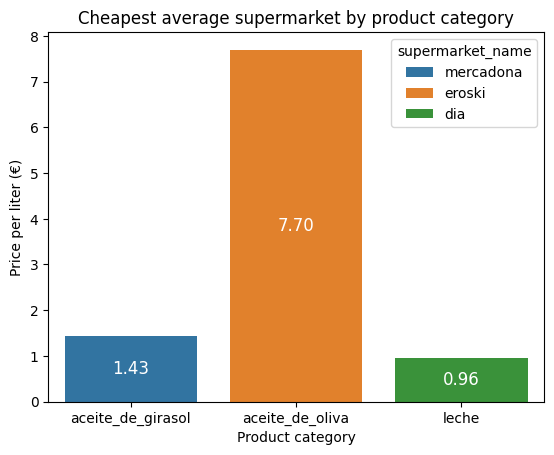

In [41]:
fig, ax = plt.subplots()

plt.title("Cheapest average supermarket by product category")

sns.barplot(data=supermarket_cheapest_category,
             x="category_name",
             y="euro_per_liter",
             hue= "supermarket_name")


# adding data labels
plot_bar_labels(ax)

plt.xlabel("Product category")
plt.ylabel("Price per liter (€)")
plt.show()

In [42]:
query = """WITH mean_price_per_unit AS (
SELECT s2.supermarket_name, c.category_name, p.units, ROUND(AVG(sp.latest_price /(p.quantity * p.volume_weight)),2) AS euro_per_liter, 
		COUNT(*) n_products, ROW_NUMBER() OVER(PARTITION BY category_name ORDER BY SUM(sp.latest_price) / SUM(p.quantity * p.volume_weight) DESC)
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
INNER JOIN brands b
	ON b.brand_id = p.brand_id
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
AND sp.latest_price /(p.quantity * p.volume_weight) < 50
GROUP BY s2.supermarket_name, c.category_name,  p.units
ORDER BY category_name, euro_per_liter)

SELECT supermarket_name, category_name, euro_per_liter
FROM mean_price_per_unit
WHERE ROW_NUMBER = 1;"""

supermarket_expensive_category = connect_and_query("comparativa_supermercados",database_credentials, query, columns="query")
supermarket_expensive_category

,supermarket_name,category_name,euro_per_liter
0,carrefour,aceite_de_girasol,3.74
1,hipercor,aceite_de_oliva,16.14
2,carrefour,leche,3.19


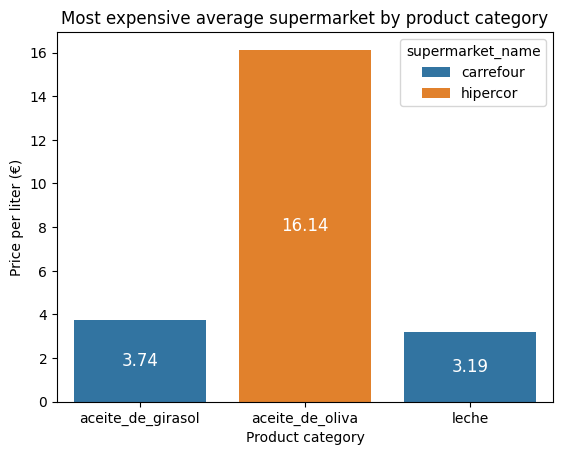

In [43]:
fig, ax = plt.subplots()

plt.title("Most expensive average supermarket by product category")

sns.barplot(data=supermarket_expensive_category,
             x="category_name",
             y="euro_per_liter",
             hue= "supermarket_name")


# adding data labels
plot_bar_labels(ax)

plt.xlabel("Product category")
plt.ylabel("Price per liter (€)")
plt.show()

What to buy and where

In [88]:
query = """WITH mean_price_per_unit AS (
SELECT  s2.supermarket_name, c.category_name, s.subcategory_name, s.distinction, quantity, volume_weight, p.units, ROUND((sp.latest_price) / (p.quantity * p.volume_weight),2) AS price_per_unit,  
		ROW_NUMBER() OVER(PARTITION BY c.category_name, s.subcategory_name, s.distinction ORDER BY (sp.latest_price) / (p.quantity * p.volume_weight) ASC) AS row_number
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
INNER JOIN brands b 
	ON p.brand_id = b.brand_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'

ORDER BY category_name, s.subcategory_name, s.distinction, price_per_unit)

SELECT category_name, subcategory_name, distinction,supermarket_name,  quantity, volume_weight, price_per_unit
FROM mean_price_per_unit
WHERE row_number = 1;"""

where_to_buy_what = connect_and_query("comparativa_supermercados",database_credentials, query, columns="query")
where_to_buy_what


,category_name,subcategory_name,distinction,supermarket_name,quantity,volume_weight,price_per_unit
0,aceite_de_girasol,freir,,carrefour,1,5.0,1.35
1,aceite_de_girasol,normal,,alcampo,1,5.0,1.38
2,aceite_de_oliva,intenso,,mercadona,1,3.0,6.45
3,aceite_de_oliva,suave,,eroski,1,1.0,4.66
4,aceite_de_oliva,virgen,,dia,1,1.0,4.99
5,aceite_de_oliva,virgen extra,,hipercor,1,5.0,7.19
6,leche,cabra,,alcampo,1,1.0,23.43
7,leche,cabra,fresca,alcampo,1,0.75,4.52
8,leche,cabra,entera,hipercor,1,1.0,4.53
9,leche,cabra,entera fresca,hipercor,1,0.75,5.77


/*Hacer análisis de las diferencias de precio por formato. */ -- aqui viene bien un scatterplot

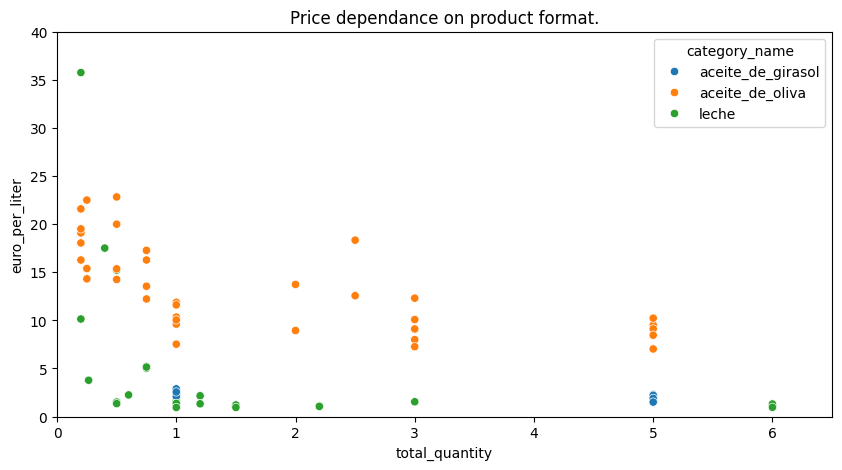

In [82]:

query = """SELECT s2.supermarket_name, c.category_name, p.quantity * p.volume_weight As total_quantity, p.units, SUM(sp.latest_price) / SUM(p.quantity * p.volume_weight) AS euro_per_liter, COUNT(*) n_products
FROM products p 
INNER JOIN subcategories s 
	ON p.subcategory_id =s.subcategory_id 
INNER JOIN categories c 
	ON s.category_id = c.category_id 
INNER JOIN supermarkets_products sp 
	ON p.product_id = sp.product_id
INNER JOIN supermarkets s2
	ON sp.supermarket_id = s2.supermarket_id 
WHERE s.subcategory_name != 'otras' -- helps distinguish not true category products, like milk hair masks o tuna in olive oil  
AND units IS NOT NULL 
AND units != 'g'
AND s.subcategory_name NOT LIKE '%otras%'
GROUP BY s2.supermarket_name, c.category_name,p.quantity * p.volume_weight, p.units
HAVING COUNT(*) > 1
ORDER BY s2.supermarket_name, c.category_name,euro_per_liter;"""

format_size = connect_and_query("comparativa_supermercados",database_credentials, query, columns="query")

fig, ax = plt.subplots(figsize=(10,5))

plt.title("Price dependance on product format.")


sns.scatterplot(
    data = format_size,
    x = "total_quantity",
    y = "euro_per_liter",
    hue="category_name",
    ax=ax
)


ax.set_ylim(0,40)
ax.set_xlim(0,6.5)
plt.show()

### Análisis temporal - evolucion de los precios

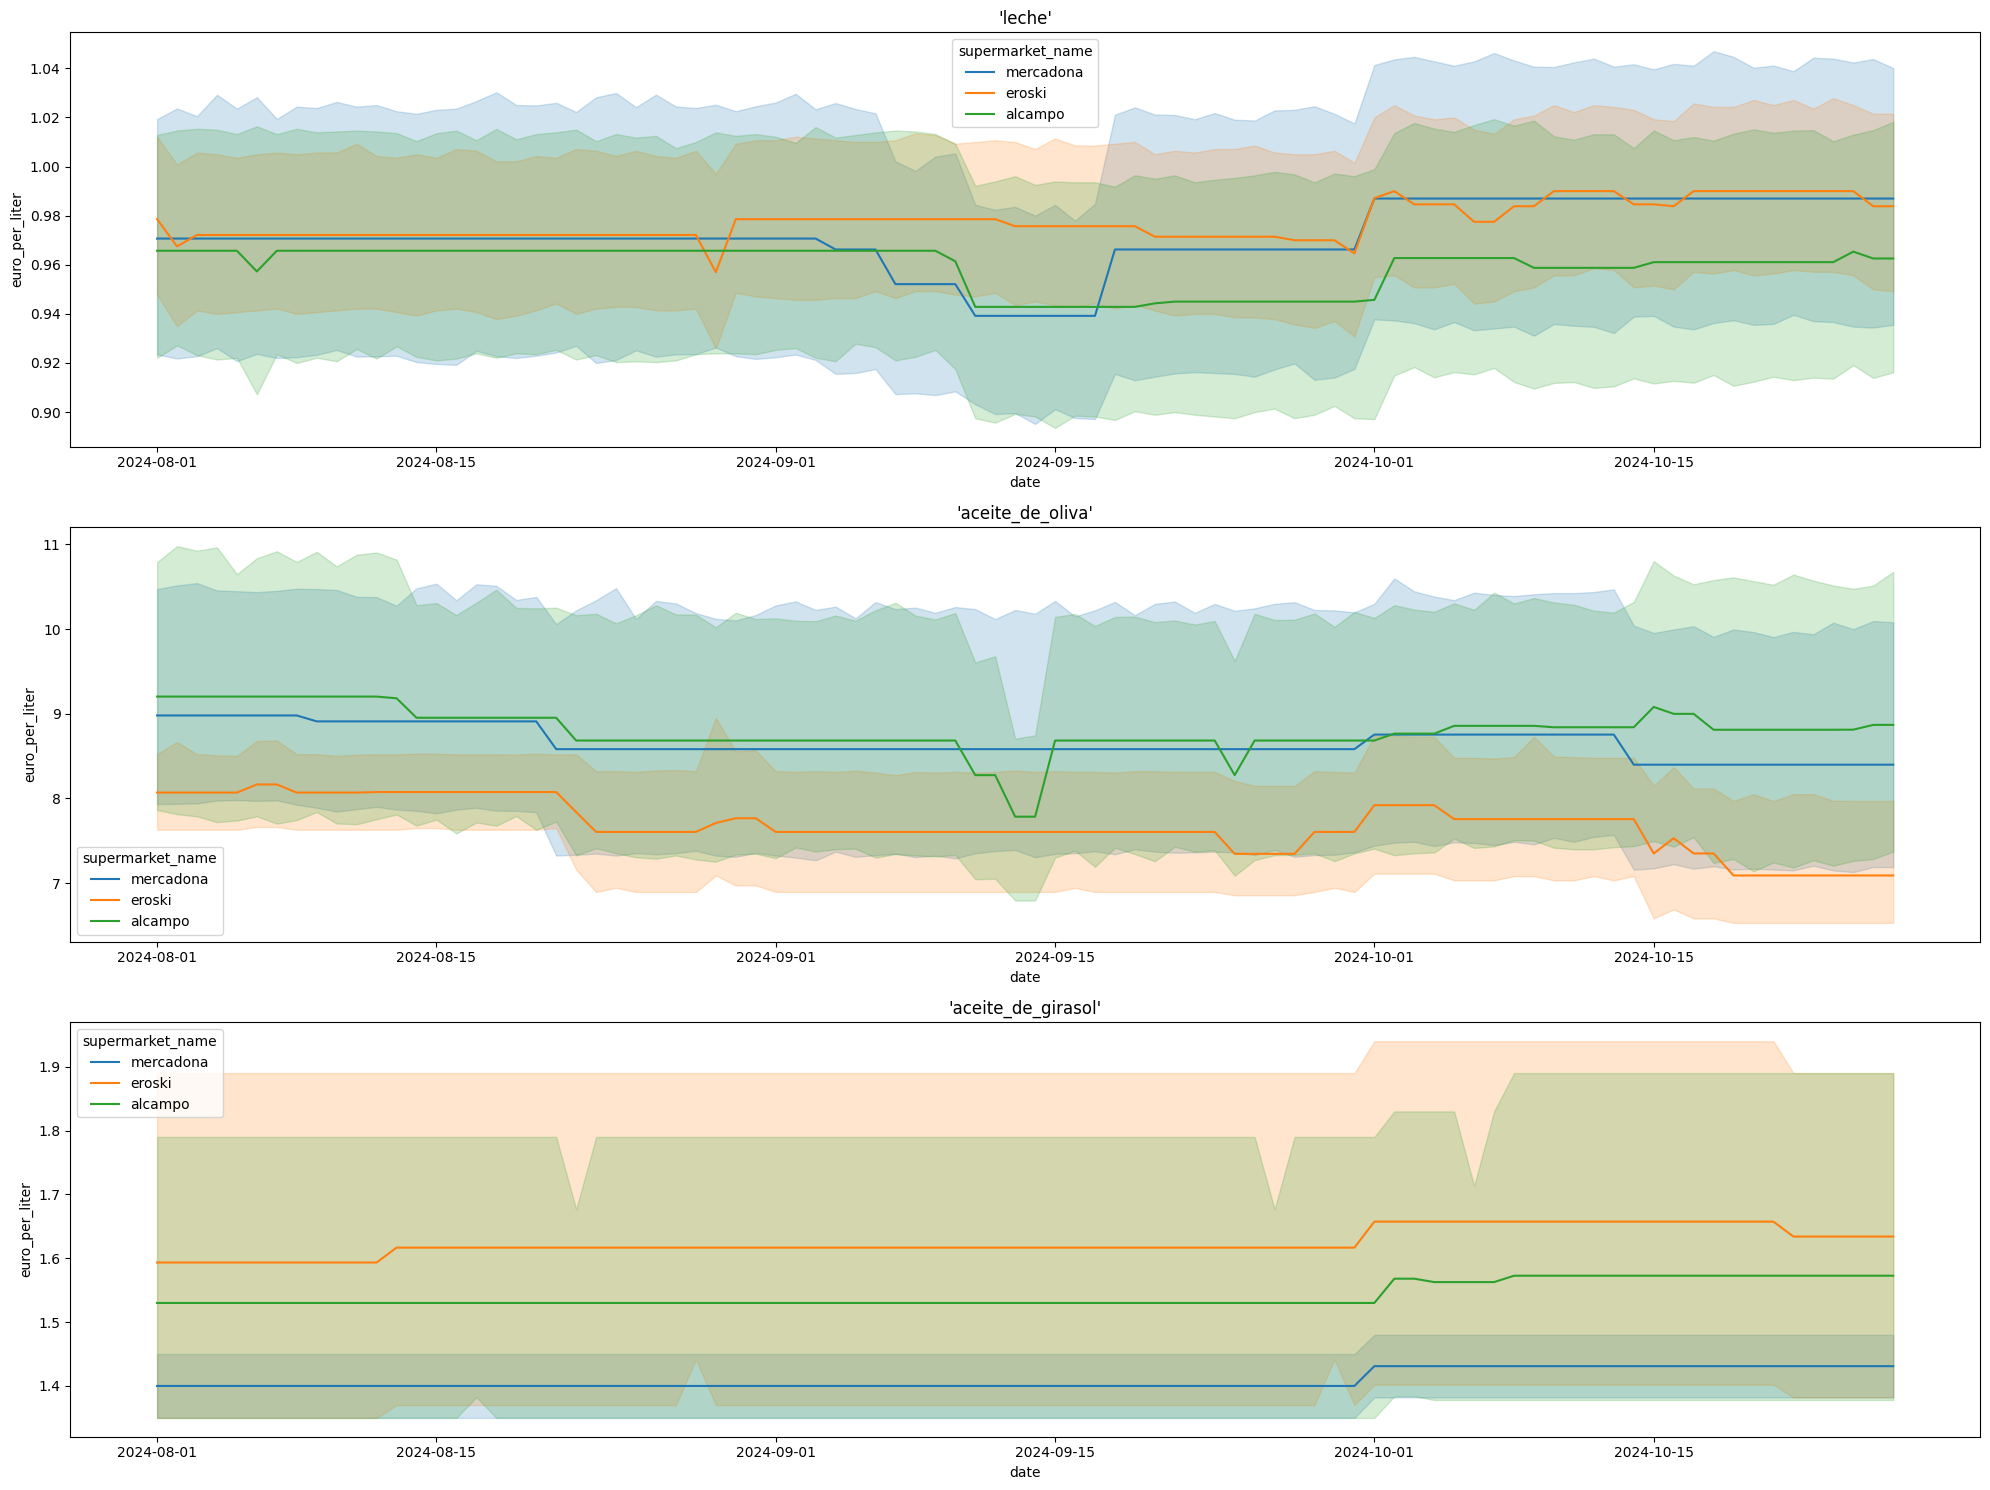

In [148]:
fig, axes = plt.subplots(3, 1, figsize=(20, 15))

axes_flat = axes.flat

for ax, category in zip(axes_flat, ["'leche'", "'aceite_de_oliva'", "'aceite_de_girasol'"]):

    query = f"""
    SELECT s2.supermarket_name, category_name, date, 
            price_amount / (p.quantity * p.volume_weight) AS euro_per_liter
    FROM products p 
    INNER JOIN subcategories s 
        ON p.subcategory_id = s.subcategory_id 
    INNER JOIN categories c 
        ON s.category_id = c.category_id 
    INNER JOIN supermarkets_products sp 
        ON p.product_id = sp.product_id
    INNER JOIN supermarkets s2
        ON sp.supermarket_id = s2.supermarket_id 
    INNER JOIN brands b
        ON b.brand_id = p.brand_id 
    INNER JOIN prices p2
        ON sp.supermarket_product_id = p2.supermarket_product_id
    WHERE s.subcategory_name != 'otras'  
    AND units IS NOT NULL 
    AND units != 'g'
    AND s.subcategory_name NOT LIKE '%otras%'
    AND subcategory_name != 'cabra'
    AND category_name = {category}
    AND supermarket_name IN ('alcampo','eroski','mercadona')
    AND brand_name IN ('alcampo','eroski','hacendado')
    AND date >= '2024-08-01'
    ORDER BY sp.supermarket_product_id, date;
    """

    timeseries = connect_and_query("comparativa_supermercados", database_credentials, query)

	
    
    sns.lineplot(
        data=timeseries,
        x="date",
        y="euro_per_liter",
        hue="supermarket_name",
        ax=ax
    )
    ax.set_title(category)


plt.tight_layout()
plt.show()


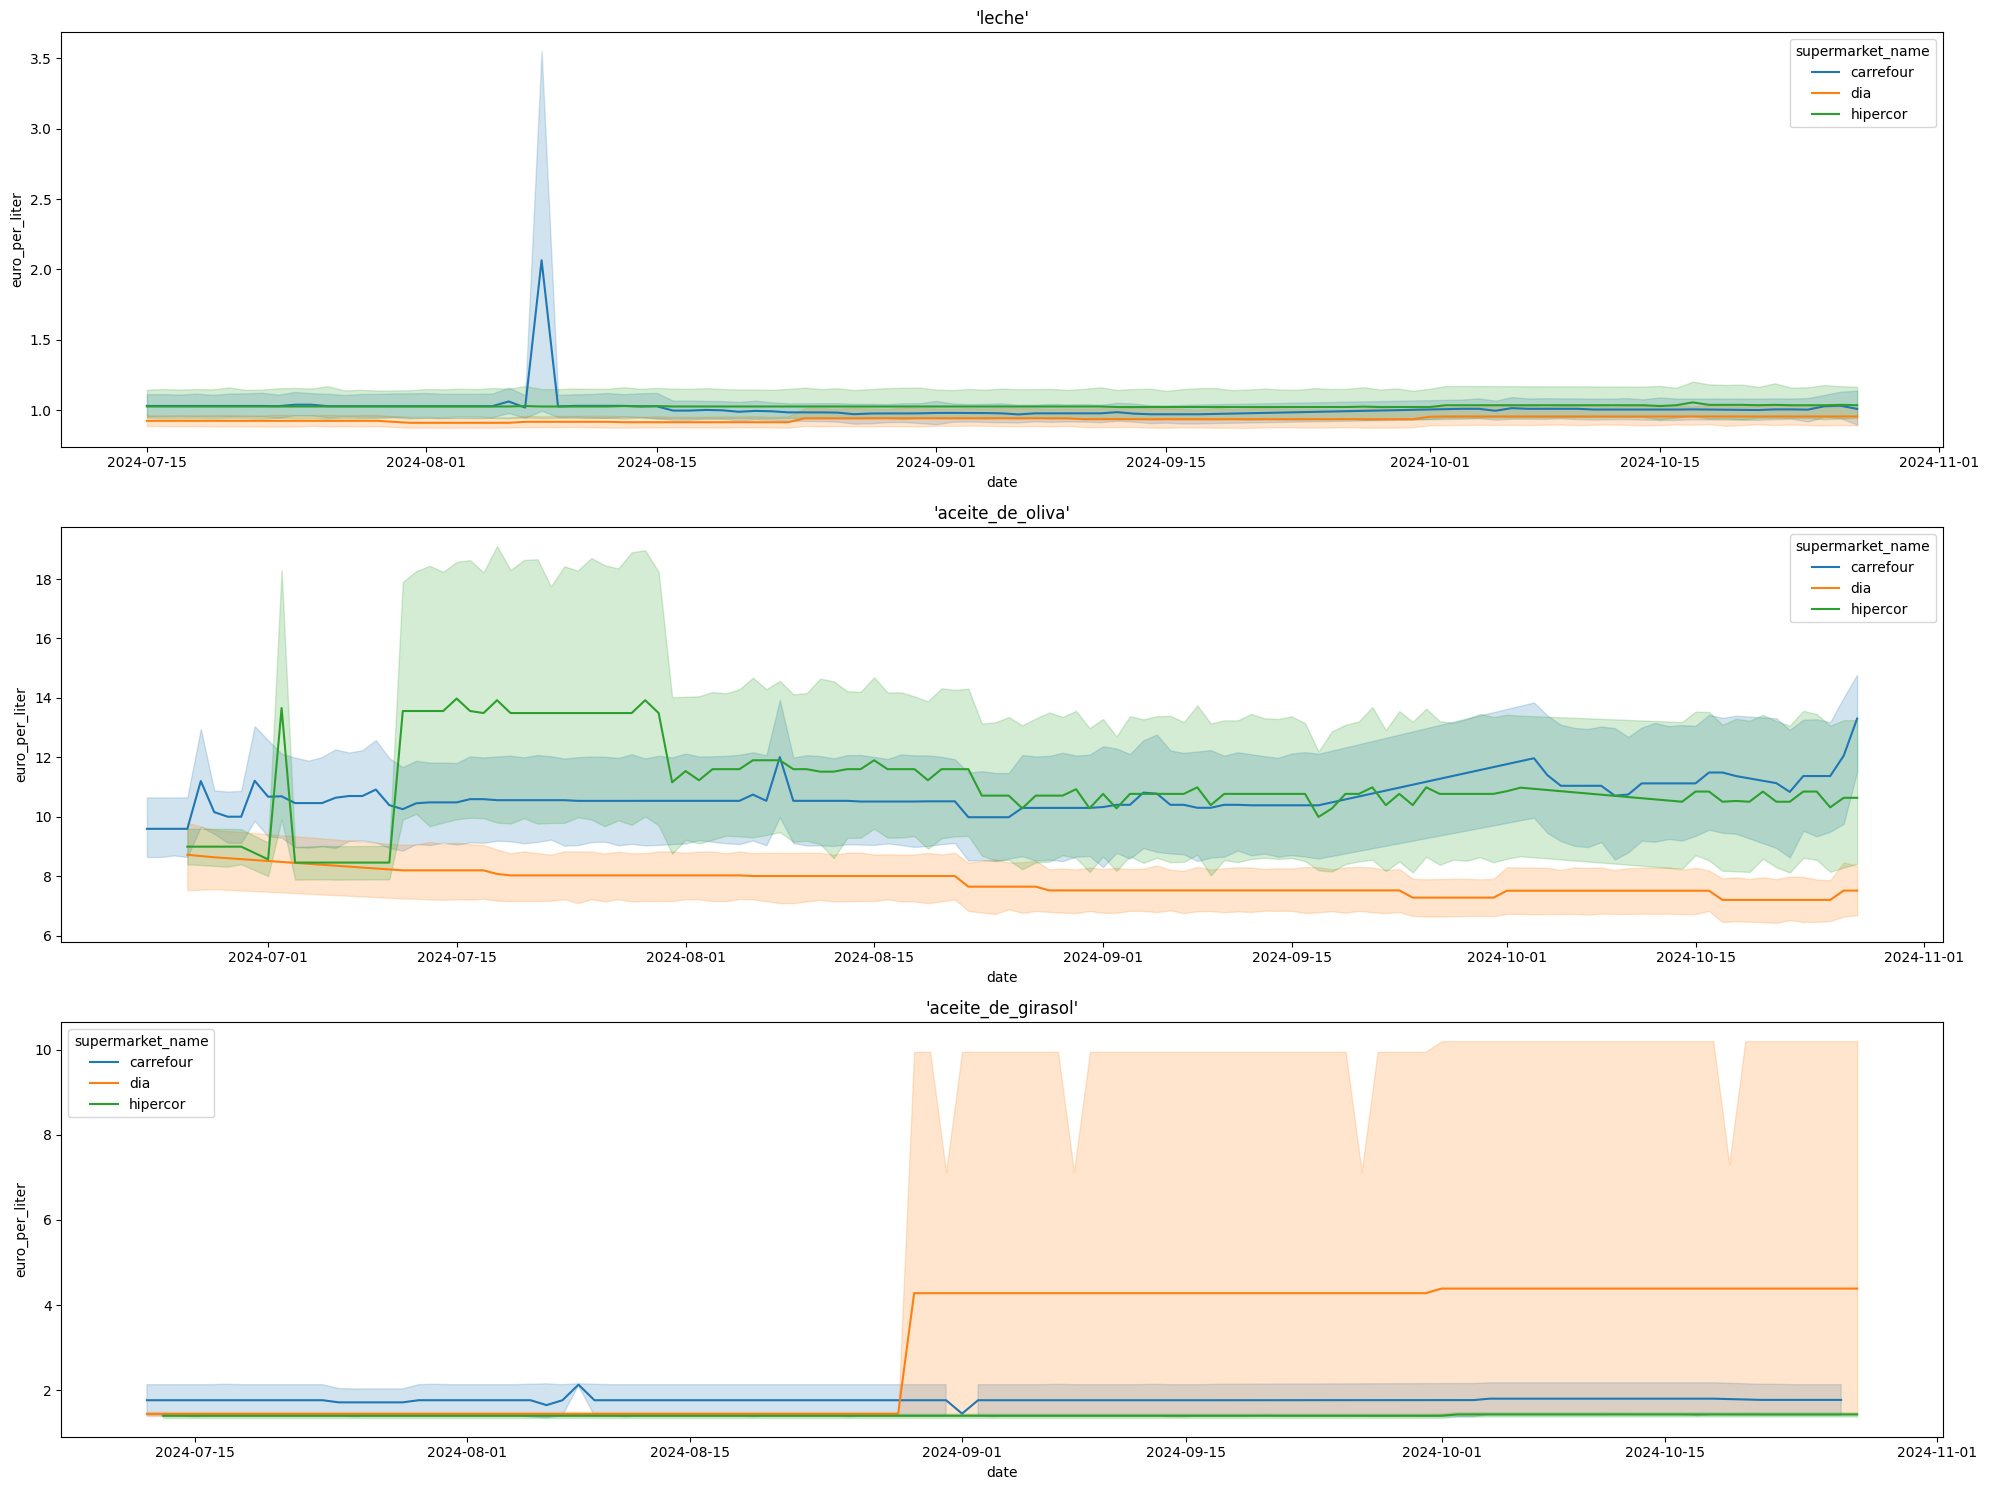

In [150]:
fig, axes = plt.subplots(3, 1, figsize=(20, 15))

axes_flat = axes.flat

for ax, category in zip(axes_flat, ["'leche'", "'aceite_de_oliva'", "'aceite_de_girasol'"]):

    query = f"""
    SELECT s2.supermarket_name, sp.product_name_supermarket, category_name, subcategory_name, date, 
            price_amount / (p.quantity * p.volume_weight) AS euro_per_liter
    FROM products p 
    INNER JOIN subcategories s 
        ON p.subcategory_id = s.subcategory_id 
    INNER JOIN categories c 
        ON s.category_id = c.category_id 
    INNER JOIN supermarkets_products sp 
        ON p.product_id = sp.product_id
    INNER JOIN supermarkets s2
        ON sp.supermarket_id = s2.supermarket_id 
    INNER JOIN brands b
        ON b.brand_id = p.brand_id 
    INNER JOIN prices p2
        ON sp.supermarket_product_id = p2.supermarket_product_id
    WHERE s.subcategory_name != 'otras'  
    AND units IS NOT NULL 
    AND units != 'g'
    AND s.subcategory_name NOT LIKE '%otras%'
    AND subcategory_name != 'cabra'
    AND category_name = {category}
    AND supermarket_name IN ('dia','hipercor','carrefour')
    AND brand_name IN ('dia','el corte ingles','carrefour')
    ORDER BY sp.supermarket_product_id, date;
    """

    timeseries = connect_and_query("comparativa_supermercados", database_credentials, query)

	
    
    sns.lineplot(
        data=timeseries,
        x="date",
        y="euro_per_liter",
        hue="supermarket_name",
        ax=ax
    )
    ax.set_title(category)


plt.tight_layout()
plt.show()


### Evolucion de los precios


    - Análisis de la Evolución de Precios: Estudiar cómo han cambiado los precios de los productos a lo largo del tiempo en distintos supermercados.

    - Detección de Anomalías: Identificar subidas o bajadas de precios inusuales que podrían señalar prácticas abusivas o promociones.




- Visualización de datos: Generar gráficos y visualizaciones que presenten de manera clara y comprensible los resultados del análisis.